In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,precision_recall_curve,accuracy_score
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB


In [23]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
plt.rcParams['font.sans-serif'] = ['Hei']#出图时防止中文字符出现乱码


In [4]:
train_df=pd.read_csv("/Users/yangshasha/data/home_credit_default_data.csv")

In [5]:
#中位数填充和最小最大值标准化（0-1）(减去最小值除以最大值减最小值），或者标准化StandardScaler(减去平均值，除以方差)
imputer = Imputer(strategy='median') #print(imputer.statistics_,显示每个特征的中位数，等同于train_df.median().values）
train_labels=train_df['TARGET']#type(train_labels)是pandas.series
train=train_df.drop(columns=['TARGET'])#type(train)是array
scaler = MinMaxScaler(feature_range=(0, 1))
imputer.fit(train)
train = imputer.transform(train)
scaler.fit(train)
train = scaler.transform(train)

/Users/yangshasha/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [6]:
print('Training data shape: ', train.shape)

train_labels=np.array(train_labels)#总训练集的labels，为方便格式，统一为array
x_train,x_test,y_train,y_test=train_test_split(train,train_labels,test_size=0.2)#分成80%的训练集和20%测试集，修改test_size=0.2


Training data shape:  (307511, 291)


In [7]:
#随机森林,auc=0.71,cart二叉树的组合，根据平均值决策，根据最小基尼系数判定先分类哪个特征

random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
random_forest.fit(x_train,y_train)#训练模型，参数都得是array或者list。利用80%的训练集学习
predictions_proba=random_forest.predict_proba(x_test)#预测20%测试集，输出的是概率
predictions=random_forest.predict(x_test)#预测20%测试集，输出的是0、1两类


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


In [20]:
#提取测试集上target值可能为1的概率值 ，循环判定 ，当这个概率大于0.15时，认为客户可能会违约
random_pred = random_forest.predict_proba(x_test)[:, 1]
y_pred=[]
for i in random_pred: 
    if i > 0.1:
           k = 1
    else: 
           k = 0
    y_pred.append(k)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.0s finished


[[39734 16799]
 [ 1860  3110]]


Text(0.5, 0, '预测类型')

<Figure size 720x432 with 0 Axes>

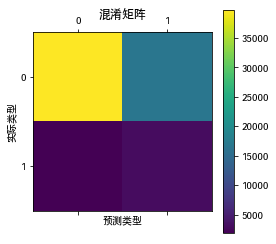

In [24]:
#测试集上混淆矩阵
print(confusion_matrix(y_test.tolist(),y_pred))
plt.figure(figsize=(10, 6))
plt.matshow(confusion_matrix(y_test.tolist(),y_pred))
plt.title('混淆矩阵')
plt.colorbar()
plt.ylabel('实际类型')
plt.xlabel('预测类型')

Text(0.5, 0, 'Fall-out')

/Users/yangshasha/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/yangshasha/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


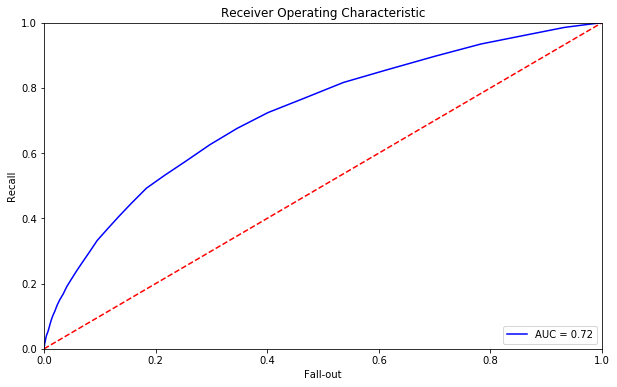

In [14]:
#画roc曲线
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions_proba[:, 1])#roc曲线指标，第一个参数为y_true,第二个参数为y_score,通过predict_proba得出
roc_auc=auc(false_positive_rate,recall)#计算auc面积
plt.figure(figsize=(10, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')

In [21]:
#打印出准确率，召回率，f1值,精确率
# 准确率
print('准确率：{:.3f}'.format(accuracy_score(y_true=y_test, y_pred=y_pred)))
# 精确率
print('精确率：{:.3f}'.format(precision_score(y_true=y_test, y_pred=y_pred)))
# 召回率
print('召回率：{:.3f}'.format(recall_score(y_true=y_test, y_pred=y_pred, average = 'macro')))
# F1值
print('F1值：{:.3f}'.format(f1_score(y_true=y_test, y_pred=y_pred)))

准确率：0.697
精确率：0.156
召回率：0.664
F1值：0.250


/Users/yangshasha/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


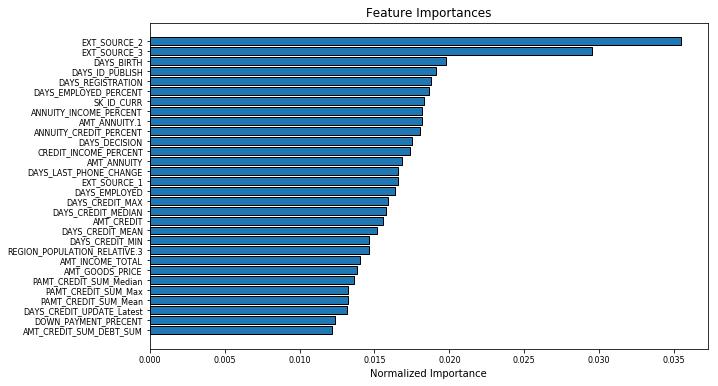

In [19]:
#画出random_forest的features importances排序
feature_importance_values = random_forest.feature_importances_
features=list(train_df.drop(columns=['TARGET']).columns)
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})
feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index()
feature_importances['importance_normalized']=feature_importances['importance']/feature_importances['importance'].sum()

plt.figure(figsize=(10, 6))
ax=plt.subplot()

ax.barh(list(reversed(list(feature_importances.index[:30]))),
         feature_importances['importance_normalized'].head(30),
         align='center', edgecolor='k')

# Set the yticks and labels
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_yticks(list(reversed(list(feature_importances.index[:30]))))
ax.set_yticklabels(feature_importances['feature'].head(30))

# Plot labeling
plt.xlabel('Normalized Importance')
plt.title('Feature Importances')

plt.show()